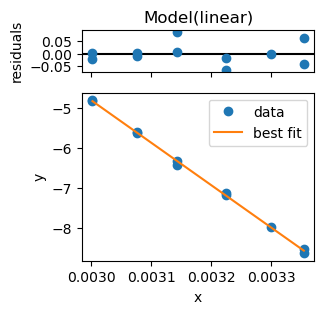

1321.5527460822657

In [1]:
import json
import numpy as np
import lmfit
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

temps = []
reps = []
kdeg_vals = []

for temp in [25, 30, 37, 45, 52, 60]:
    for rep in ['a', 'b']:
        if temp == 30 and rep =='b':
            continue
        # read json-like file /home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/52_a.sav
        with open(f'/home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/{temp}_{rep}.sav') as f:
            data = json.load(f)
        kdeg_val = 1 / data['params'][1][1]
        temps.append(temp)
        reps.append(rep)
        kdeg_vals.append(kdeg_val)

df_kdeg = pd.DataFrame({'temperature': temps, 'replicate': reps, 'kdeg': kdeg_vals})
df_kdeg['lnkdeg'] = np.log(df_kdeg['kdeg'])
df_kdeg['inv_temp'] = 1 / (df_kdeg['temperature'] + 273.15)

# linear fit to get curve
model = lmfit.models.LinearModel()
params = model.make_params()
result = model.fit(df_kdeg['lnkdeg'], params, x=df_kdeg['inv_temp'])
result.plot(fig_kws={'figsize': (3, 3)})
plt.show()

# get slope and intercept
slope = result.params['slope'].value
intercept = result.params['intercept'].value

def get_kdeg(temp, slope=slope, intercept=intercept):
    
    return np.exp(slope / (temp + 273.15) + intercept)

1 / get_kdeg(37)

In [2]:
def fmod_model(x, log_kappa, log_kdeg, log_fmod_0):
    kappa = np.exp(log_kappa)
    kdeg = np.exp(log_kdeg)
    fmod_0 = np.exp(log_fmod_0)
    return 1 - np.exp(- (kappa) * (1 - np.exp(-kdeg * x))) + fmod_0

def fit_df(df, temp):
    site_nt = df['site'].astype(str).values[0] + df['base'].values[0]

    x_data = df['reaction_time']
    y_data = df['fmod_val']

    # Create an lmfit model
    model = lmfit.Model(fmod_model)

    kdeg0 = get_kdeg(temp)
    kappa0 = kdeg0 / (10**-1)  # Assume kdeg = 10^-3 * kappa
    fmod_00 = max(y_data.min(), 1e-6)  # Avoid log(0) errors
    
    params = model.make_params(
        log_kappa=np.log(kappa0), 
        log_kdeg=np.log(kdeg0), 
        log_fmod_0=np.log(fmod_00)
    )
    
    # No constraints needed since we fit in log space
    result = model.fit(y_data, params, x=x_data)
    
    # Remove outlier outside of 1.5σ and refit
    outlier = np.abs(result.residual) > 1.5 * np.std(result.residual)
    
    if sum(outlier) > 0:
        x_data = x_data[~outlier]
        y_data = y_data[~outlier]
    
        # Initial values = values from previous fit
        params = model.make_params(
            log_kappa=result.best_values['log_kappa'], 
            log_kdeg=result.best_values['log_kdeg'], 
            log_fmod_0=result.best_values['log_fmod_0']
        )
        
        result = model.fit(y_data, params, x=x_data)

    return result, site_nt, outlier

In [3]:
# initialize an empty db with 'construct', 'site', 'site_nt', 'buffer', 'temp', 'kobs_val', 'kobs_err', 'kdeg_val', 'kdeg_err', 'fmod0', 'fmod0_err', 'r2', 'stderr'
store_free_fits = '/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/store_free_fits.db'
conn = sqlite3.connect(store_free_fits)
cursor = conn.cursor()

# Create table
cursor.execute('''
CREATE TABLE IF NOT EXISTS fit_results (
    construct TEXT,
    site INTEGER,
    site_nt TEXT,
    buffer INTEGER,
    temp INTEGER,
    kobs_val REAL,
    kobs_err REAL,
    kdeg_val REAL,
    kdeg_err REAL,
    fmod0 REAL,
    fmod0_err REAL,
    r2 REAL,
    stderr REAL
)
''')

conn.commit()
conn.close()

db_path = '/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.060.developing_DB_input/new.db'
conn = sqlite3.connect(db_path)
# Execute the query with the provided parameters
rg_ids = list(pd.read_sql("SELECT DISTINCT rg.rg_id FROM reaction_groups rg;", conn)['rg_id'])
conn.close()

# Define the query to get fmod_val and reaction_time with a join between the necessary tables
query = """
    SELECT fv.fmod_val, pr.reaction_time, n.site, n.base, pr.treated, fv.read_depth, pr.RT, fv.valtype, pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id
    FROM probing_reactions pr
    JOIN fmod_vals fv ON pr.id = fv.rxn_id
    JOIN nucleotides n ON fv.nt_id = n.id
    JOIN constructs c ON pr.construct_id = c.id
    JOIN sequencing_samples ss ON pr.s_id = ss.id
    JOIN reaction_groups rg ON rg.rxn_id = pr.id
    JOIN sequencing_runs sr on ss.seqrun_id = sr.id
    WHERE rg.rg_id = ?
    AND pr.reaction_time IN (
        SELECT pr2.reaction_time
        FROM probing_reactions pr2
        GROUP BY pr2.reaction_time
        HAVING COUNT(DISTINCT pr2.id) > 1
    )
    AND fv.fmod_val IS NOT NULL
    AND pr.RT = 'MRT'
    AND fv.valtype = 'modrate'
"""

for rg_id in rg_ids:
    conn = sqlite3.connect(db_path)
    # Execute the query with the provided parameters
    df = pd.read_sql(query, conn, params=(rg_id, ))
    conn.close()

    # if df is empty, continue
    if len(df) == 0:
        continue

    construct = df['disp_name'].values[0]
    buffer = df['buffer_id'].values[0]
    temp = df_site['temperature'].values[0]
    print(f'Processing rg_id: {rg_id} -- {construct} -- {buffer} -- {temp}')
    store_results = []
    for site in df['site'].unique():
        df_site = df[df['site'] == site].copy()
        df_site.loc[:, 'reaction_time'] = df_site['reaction_time'] * df_site['treated']
        df_site = df_site.sort_values(by=['reaction_time'])
        df_site = df_site[df_site['read_depth'] > 500]
        if len(df_site) < 4:
            continue

        try:
            result, site_nt, outliers = fit_df(df_site, temp)
            kappa = np.exp(result.params['log_kappa'].value)
            kdeg = np.exp(result.params['log_kdeg'].value)
            fmod_0 = np.exp(result.params['log_fmod_0'].value)
        except:
            print('fit fail')
            continue

        # if any of the params values or stderr are none, continue
        if any([result.params['log_kappa'].value is None, result.params['log_kappa'].stderr is None, 
                result.params['log_kdeg'].value is None, result.params['log_kdeg'].stderr is None, 
                result.params['log_fmod_0'].value is None, result.params['log_fmod_0'].stderr is None]):
            continue

        store_results.append([construct, site, site_nt, buffer, temp,
                            kappa, kappa * result.params['log_kappa'].stderr, 
                            kdeg, kdeg * result.params['log_kdeg'].stderr, 
                            fmod_0, fmod_0 * result.params['log_fmod_0'].stderr,
                            result.rsquared, 
                            result.params['log_kappa'].stderr])

    fit_results = pd.DataFrame(store_results, columns=['construct', 'site', 'site_nt', 'buffer', 'temp', 'kobs_val', 'kobs_err', 'kdeg_val', 'kdeg_err', 'fmod0', 'fmod0_err', 'r2', 'stderr'])
    # append to store_free_fits db
    conn = sqlite3.connect(store_free_fits)
    fit_results.to_sql('fit_results', conn, if_exists='append', index=False)
    conn.close()
# remove duplicates

#fit_results = fit_results.drop_duplicates()
#fit_results.to_csv(f'/home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.057.P4P6_WT_dms/01.057.03.initial_freefits/initial_free_fits_with_db_import/{temp}_{modrate}_{rt}_fit_results.csv', index=False)


NameError: name 'df_site' is not defined

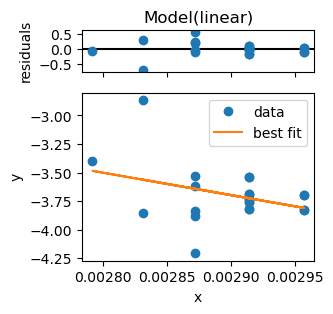

In [3]:
store_free_fits = '/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/store_free_fits.db'

conn = sqlite3.connect(store_free_fits)

# read to pd
fit_results = pd.read_sql('SELECT * FROM fit_results', conn)
# filter R2 > 0.7
fit_results = fit_results[fit_results['r2'] > 0.7]
high_temps = fit_results[fit_results['temp'] > 60]

site_df_melt = high_temps[(high_temps['site_nt'] == '18A')]
# fit log(kobs_val) ~ 1/T
model = lmfit.models.LinearModel()
params = model.make_params()
result = model.fit(np.log(site_df_melt['kobs_val']), params, x=1 / (site_df_melt['temp'] + 273.15))

# outlier removal
outlier = np.abs(result.residual) > 1.5 * np.std(result.residual)
site_df_melt = site_df_melt[~outlier]
result = model.fit(np.log(site_df_melt['kobs_val']), params, x=1 / (site_df_melt['temp'] + 273.15))


result.plot(fig_kws={'figsize': (3, 3)})
plt.show()

In [4]:
import seaborn as sns


/tmp/ipykernel_96327/274837933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site18A['kadd_S'] = site18A['kobs_val'] * site18A['kdeg_val']
/tmp/ipykernel_96327/274837933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site18A['kadd_val'] = site18A['kadd_S'] / 0.001583
/tmp/ipykernel_96327/274837933.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

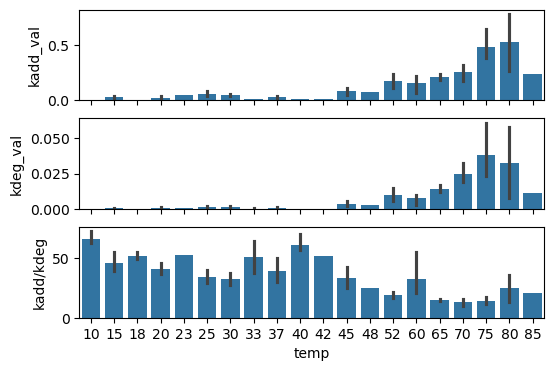

In [7]:
site18A = fit_results[fit_results['site_nt'] == '18A']
site18A['kadd_S'] = site18A['kobs_val'] * site18A['kdeg_val']
site18A['kadd_val'] = site18A['kadd_S'] / 0.001583
site18A['kadd/kdeg'] = site18A['kadd_val'] / site18A['kdeg_val']

fig, axs = plt.subplots(3, 1, figsize = (6, 4), sharex = True)
# group by temp and plot bar using sns
sns.barplot(data=site18A, x='temp', y='kadd_val', ax = axs[0])
sns.barplot(data=site18A, x='temp', y='kadd/kdeg', ax = axs[2])
sns.barplot(data=site18A, x='temp', y='kdeg_val', ax = axs[1])
plt.show()

/tmp/ipykernel_96327/3515862453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site18A['kadd_S/kdeg'] = site18A['kadd_S'] / site18A['kdeg_val']


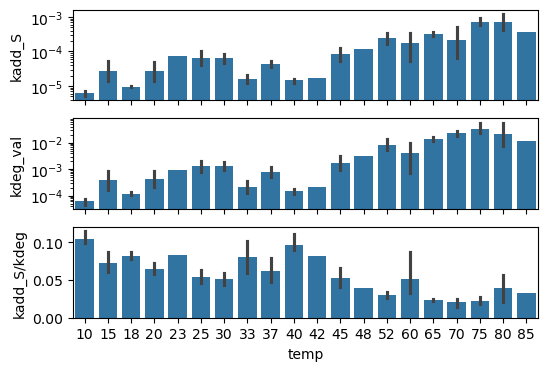

In [10]:
site18A['kadd_S/kdeg'] = site18A['kadd_S'] / site18A['kdeg_val']

fig, axs = plt.subplots(3, 1, figsize = (6, 4), sharex = True)
# group by temp and plot bar using sns
sns.barplot(data=site18A, x='temp', y='kadd_S', ax = axs[0], log = True)
sns.barplot(data=site18A, x='temp', y='kadd_S/kdeg', ax = axs[2])
sns.barplot(data=site18A, x='temp', y='kdeg_val', ax = axs[1], log = True)
plt.show()

/tmp/ipykernel_143134/2343936357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site18A['set_endpt'] = 1 - np.exp(-site18A['kobs_val']* (1 - np.exp(-site18A['kdeg_val'] * 1800)))
/tmp/ipykernel_143134/2343936357.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site18A['endpt'] = 1 - np.exp(-site18A['kobs_val'])
/home/ekc5108/.conda/envs/nupack/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwar

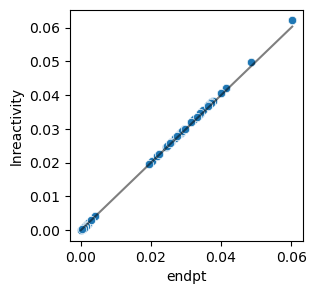

In [20]:
site18A = fit_results[(fit_results['temp'] == 70) & (fit_results['construct'] == '4U_wt')]
site18A['set_endpt'] = 1 - np.exp(-site18A['kobs_val']* (1 - np.exp(-site18A['kdeg_val'] * 1800)))
site18A['endpt'] = 1 - np.exp(-site18A['kobs_val'])
site18A['lnreactivity'] = -np.log(1 - site18A['endpt'] )
# filter endpt < 1
site18A = site18A[site18A['endpt'] < 1]
# plot
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
sns.scatterplot(data=site18A, x='endpt', y='lnreactivity', ax = ax)
# draw x=y line
ax.plot([0, site18A['endpt'].max()], [0, site18A['endpt'].max()], color='black', linestyle='-', alpha=0.5)
plt.show()

<AxesSubplot:xlabel='temp', ylabel='endpt'>

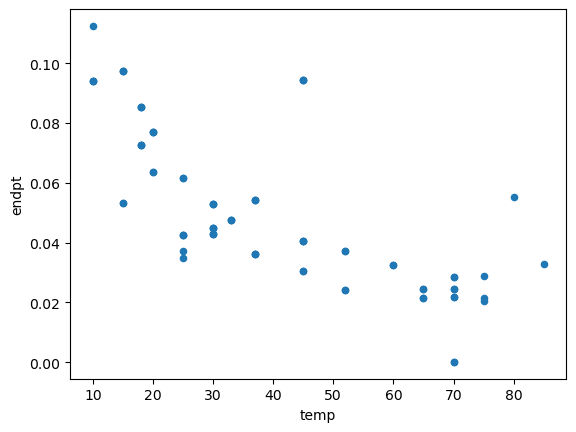

In [24]:
fit_results['endpt'] = 1 - np.exp(-fit_results['kobs_val'])
fit_results[(fit_results['construct'] == '4U_wt')& (fit_results['site_nt'] == '18A')].plot(x='temp', y='endpt', kind='scatter')

In [62]:
fit_results[(fit_results['temp'] == 37) & (fit_results['construct'] == '4U_wt')& (fit_results['site_nt'] == '18A')]

,construct,site,site_nt,buffer,temp,kobs_val,kobs_err,kdeg_val,kdeg_err,fmod0,fmod0_err,r2,stderr
64,4U_wt,18,18A,1,37,0.055626,0.001170,0.001113,0.000057,0.000812,0.000963,0.998748,0.021042
1040,4U_wt,18,18A,1,37,0.036750,0.002056,0.001343,0.000192,0.001329,0.001719,0.991046,0.055941
1765,4U_wt,18,18A,1,37,0.055626,0.001170,0.001113,0.000057,0.000812,0.000963,0.998748,0.021042
3068,4U_wt,18,18A,1,37,0.036750,0.002056,0.001343,0.000192,0.001329,0.001719,0.991046,0.055941
4016,4U_wt,18,18A,1,37,0.055626,0.001170,0.001113,0.000057,0.000812,0.000963,0.998748,0.021042
5456,4U_wt,18,18A,1,37,0.036750,0.002056,0.001343,0.000192,0.001329,0.001719,0.991046,0.055941


In [60]:
site18A.sort_values(by='endpt')

,construct,site,site_nt,buffer,temp,kobs_val,kobs_err,kdeg_val,kdeg_err,fmod0,fmod0_err,r2,stderr,endpt,lnreactivity
1906,4U_wt,62,62G,1,25,6.041244e-05,6.758014e-06,7.113285e-03,3.252705e-03,0.000111,0.000004,0.931352,0.111865,0.000060,0.000060
202,4U_wt,62,62G,1,25,6.041244e-05,6.758014e-06,7.113285e-03,3.252705e-03,0.000111,0.000004,0.931352,0.111865,0.000060,0.000060
4134,4U_wt,62,62G,1,25,6.041244e-05,6.758014e-06,7.113285e-03,3.252705e-03,0.000111,0.000004,0.931352,0.111865,0.000060,0.000060
4618,4U_wt,12,12T,1,25,1.033004e-04,5.099276e-05,4.558428e-04,4.740794e-04,0.000607,0.000050,0.725772,0.493636,0.000103,0.000103
295,4U_wt,12,12T,1,25,1.033007e-04,5.099275e-05,4.558480e-04,4.740859e-04,0.000607,0.000050,0.725772,0.493634,0.000103,0.000103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4U_wt,27,27G,1,25,1.772768e+07,1.525031e+08,5.990988e-16,5.037137e-15,0.001033,0.000032,0.971489,8.602542,1.000000,inf
2183,4U_wt,6,6G,1,25,2.208176e+07,3.639198e+08,4.433139e-16,7.411879e-15,0.000984,0.000049,0.714531,16.480558,1.000000,inf
1028,4U_wt,31,31G,1,25,1.610313e+06,1.593042e+08,2.498663e-14,2.468002e-12,0.001155,0.000047,0.876472,98.927475,1.000000,inf
3053,4U_wt,31,31G,1,25,1.464107e+07,3.412100e+08,2.743494e-15,6.524475e-14,0.001155,0.000071,0.876472,23.304987,1.000000,inf


/tmp/ipykernel_56816/4290686070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site18A['endpt'] = 1 - np.exp(-site18A['kobs_val'])
/home/ekc5108/.conda/envs/nupack/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_56816/4290686070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site18A['lnreactivity'] = -np.log(1 - site18A['endpt'])


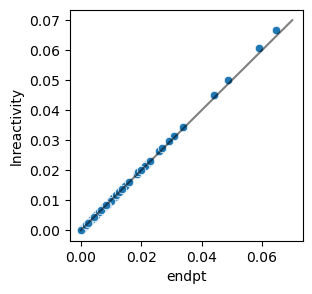

In [55]:
site18A = fit_results[(fit_results['temp'] == 23) & (fit_results['construct'] == 'p4p6_wt_nobc')]
site18A['endpt'] = 1 - np.exp(-site18A['kobs_val'])
site18A['lnreactivity'] = -np.log(1 - site18A['endpt'])

# plot
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
sns.scatterplot(data=site18A, x='endpt', y='lnreactivity', ax = ax)
# draw x=y line
ax.plot([0, 0.07], [0, 0.07], color='black', linestyle='-', alpha=0.5)
plt.show()